# Data and packages

In [1]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [2]:
os.getcwd()

'/Users/rafaeldossantospeixoto/Library/CloudStorage/OneDrive-JohnsHopkins/jefworks/crawdad/repos/crawdad_revision_analysis/running_code/squidpy'

In [3]:
meta = datatable.fread("exported_data/df_nullsim_s0.csv")
meta = meta.to_pandas().set_index('C0')
meta.head()

,x,y,celltypes
C0,,,
cell1,896.697200,387.112989,D
cell2,265.508663,871.805021,D
cell3,372.123900,967.197048,D
cell4,572.853363,866.916271,D
cell5,908.207790,437.715302,A


In [4]:
meta.shape

(2000, 3)

# Squidpy

In [5]:
# just some random data for gene expression because I'm just interested in getting the coordinates and labels in there
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(2000, 50)

In [6]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})

In [7]:
adata.obs = meta

In [8]:
adata.obs

,x,y,celltypes
C0,,,
cell1,896.697200,387.112989,D
cell2,265.508663,871.805021,D
cell3,372.123900,967.197048,D
cell4,572.853363,866.916271,D
cell5,908.207790,437.715302,A
...,...,...,...
cell1996,337.503235,212.108395,B
cell1997,775.028235,585.793459,C
cell1998,69.070202,842.366851,C


/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


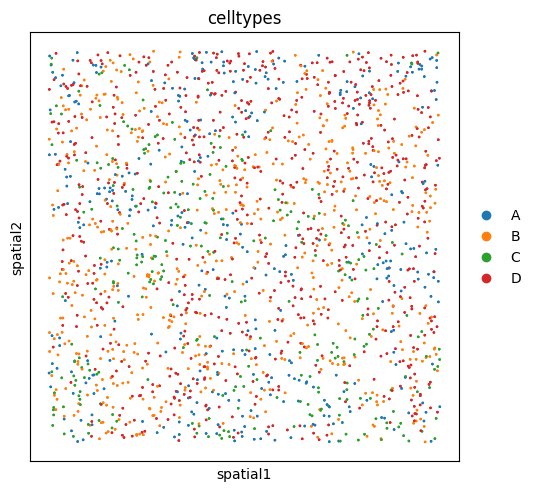

In [9]:
sq.pl.spatial_scatter(
        adata,
        shape = None,
        color = "celltypes",
        size=3
)

In [10]:
## change scale to 500
sq.gr.co_occurrence(adata, cluster_key = "celltypes", interval=np.linspace(1, 500, num=50))


/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:02<00:00,  2.32s/]


In [11]:
adata

AnnData object with n_obs × n_vars = 2000 × 50
    obs: 'x', 'y', 'celltypes'
    uns: 'celltypes_colors', 'celltypes_co_occurrence'
    obsm: 'spatial'

In [12]:
## get the co-occurance values
occ = adata.uns["celltypes_co_occurrence"]["occ"]
occ.shape

(4, 4, 49)

In [13]:
## get the intervals
intervals = adata.uns["celltypes_co_occurrence"]["interval"]
intervals.shape

(50,)

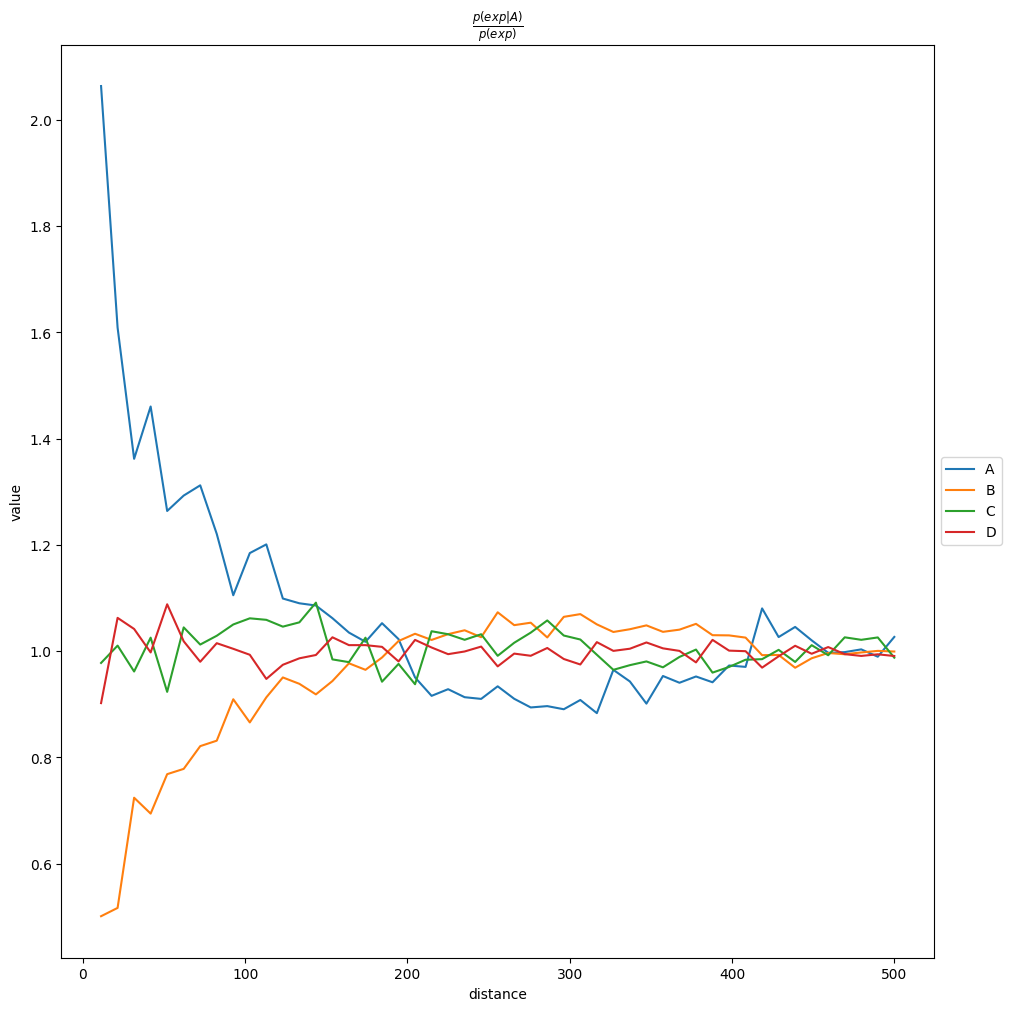

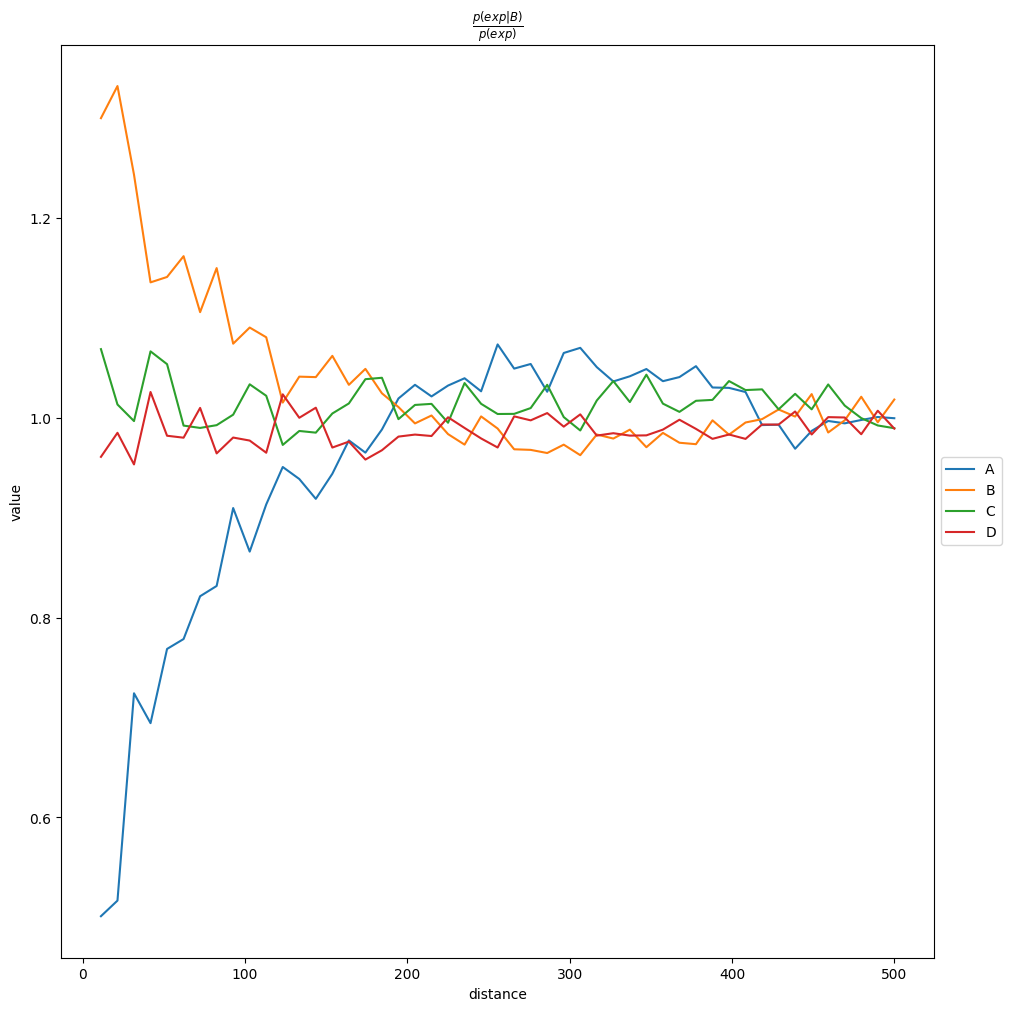

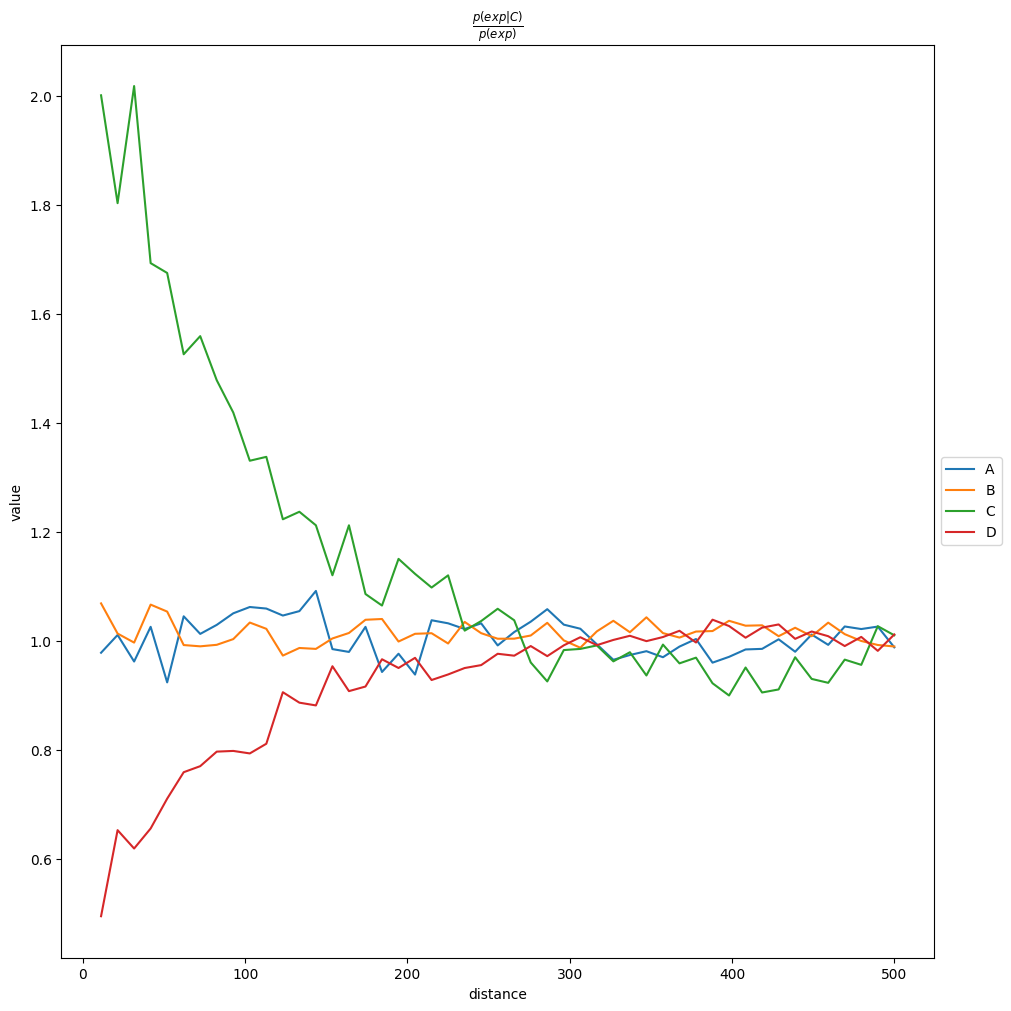

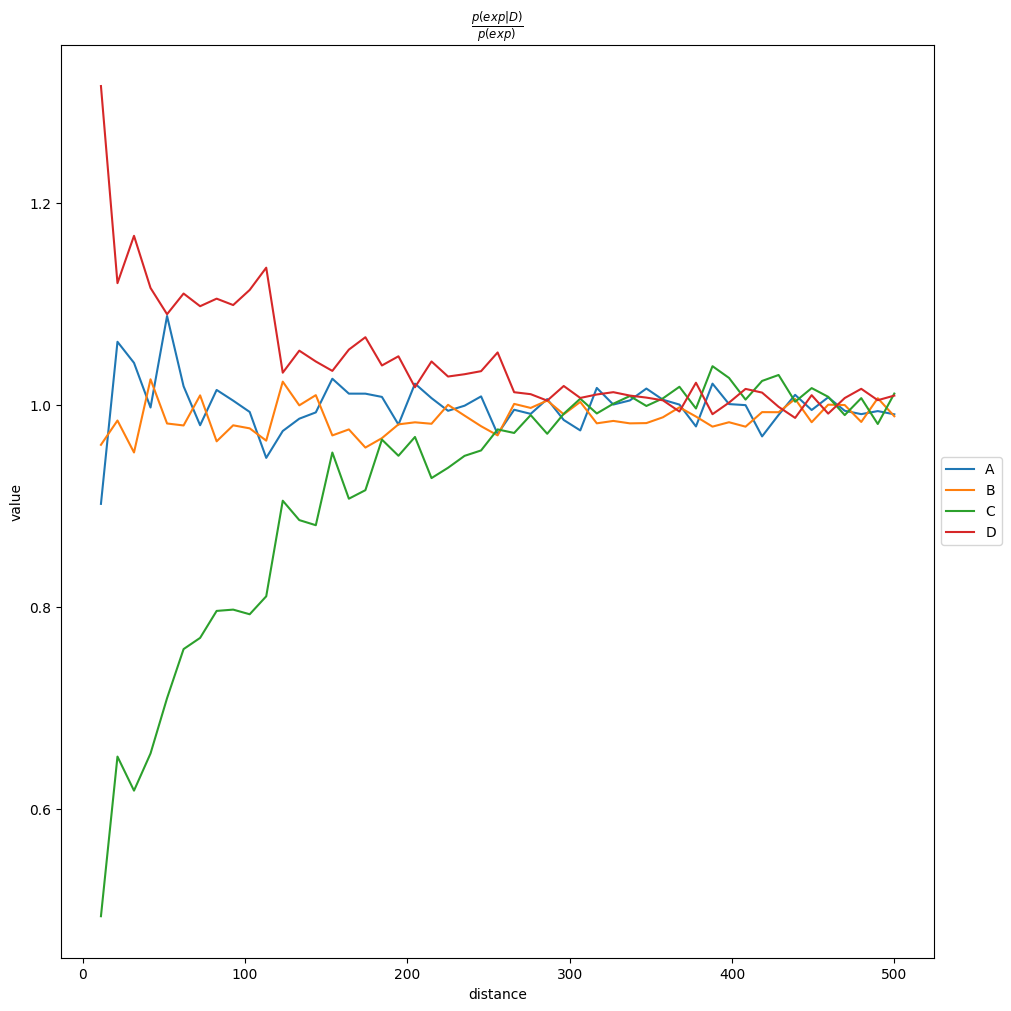

In [14]:
for ct in np.unique(adata.obs["celltypes"]):
    sq.pl.co_occurrence(adata, cluster_key="celltypes", clusters=ct,
                        save="simulation_co_occurance.{}.pdf".format(ct),
                        figsize=(10,10))

# Extract data

In [15]:
out = adata.uns["celltypes_co_occurrence"]["occ"]
interval = adata.uns["celltypes_co_occurrence"]["interval"][1:]
categories = adata.obs["celltypes"].cat.categories

In [16]:
print(type(out), type(interval), type(categories))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.indexes.base.Index'>


In [17]:
# Write CSV file
""" with open("out_sim.csv", "wt") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerows(out) """

' with open("out_sim.csv", "wt") as fp:\n    writer = csv.writer(fp, delimiter=",")\n    writer.writerows(out) '

In [18]:
categories

Index(['A', 'B', 'C', 'D'], dtype='object')

In [19]:
# Write CSV file
""" with open("results_data/interval_sim.csv", "wt") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerows(map(lambda x: [x], interval)) """

' with open("results_data/interval_sim.csv", "wt") as fp:\n    writer = csv.writer(fp, delimiter=",")\n    writer.writerows(map(lambda x: [x], interval)) '

In [20]:
# Write CSV file
""" with open("categories_sim.csv", "wt") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerows(categories) """

' with open("categories_sim.csv", "wt") as fp:\n    writer = csv.writer(fp, delimiter=",")\n    writer.writerows(categories) '

## Create DF

In [21]:
cluster_key = "celltypes"

In [22]:
clusters = categories

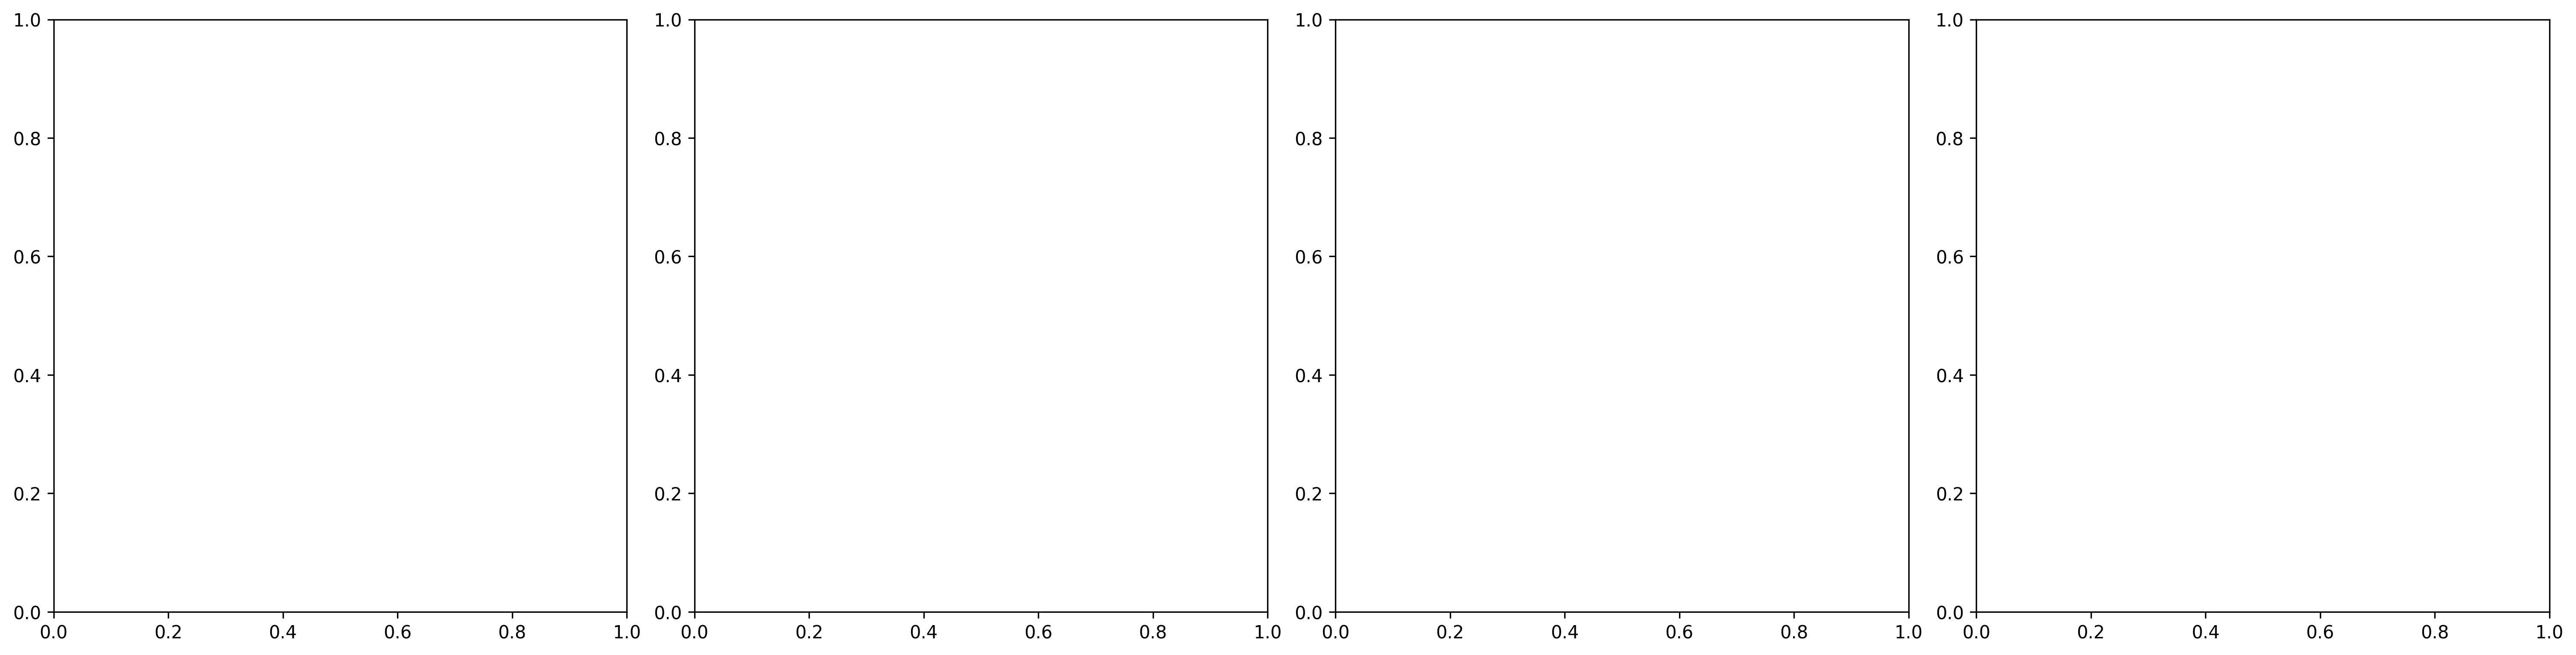

In [23]:
fig, axs = plt.subplots(
        1,
        len(clusters),
        figsize=(5 * len(clusters), 5),
        dpi=300,
        constrained_layout=True,
    )
axs = np.ravel(axs)

In [24]:
df_dict = {}

for g, ax in zip(clusters, axs):
        print(g)
        idx = np.where(categories == g)[0][0]
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        ## is g the reference or the neighbor? the way they plot, looks like the ref since it is one loop for plot
        df["reference"] = g
        df_dict[g] = df


A
B
C
D


In [25]:
result_df = pd.concat(df_dict.values(), axis=0, keys=df_dict.keys(), ignore_index=True)
result_df.head()

,celltypes,probability,distance,reference
0,A,2.063922,11.183674,A
1,A,1.609233,21.367348,A
2,A,1.362189,31.551020,A
3,A,1.460687,41.734695,A
4,A,1.264001,51.918365,A


In [26]:
# > names(dat_50)
# [1] "perm"      "neighbor"  "Z"         "scale"     "reference" "id" 
# result_df.columns = ["neighbor", "Z", "scale", "reference"]
result_df.columns = ["neighbor", "probability", "distance", "reference"]

In [27]:
result_df["id"] = 0
result_df["perm"] = 1
result_df.head()

,neighbor,probability,distance,reference,id,perm
0,A,2.063922,11.183674,A,0,1
1,A,1.609233,21.367348,A,0,1
2,A,1.362189,31.551020,A,0,1
3,A,1.460687,41.734695,A,0,1
4,A,1.264001,51.918365,A,0,1


In [28]:
result_df.to_csv('results_data/dat_nullsim_squidpy.csv')